In [47]:
from sage.sets.family import Family
from sage.rings.rational_field import QQ
from sage.modules.with_basis.subquotient import SubmoduleWithBasis
from sage.misc.cachefunc import cached_method
from sage.matrix.constructor import matrix
from sage.combinat.symmetric_group_algebra import e
from sage.combinat.permutation import Permutation
from sage.combinat.partition import Partition
from sage.combinat.diagram import Diagram
from sage.categories.modules_with_basis import ModulesWithBasis
from sympy.polys.matrices import DomainMatrix
from sympy.physics.quantum.matrixutils import matrix_tensor_product
from sympy import Matrix, SparseMatrix, eye
import matplotlib.pyplot as plt
import numpy
import os.path
import json
import itertools
import networkx as nx
Symqt = SymmetricFunctions(QQ)
s = Symqt.s()
sp = Symqt.sp()
e = Symqt.e()
p = Symqt.p()

In [98]:
from sage.categories.modules_with_basis import ModulesWithBasis
from sage.combinat.diagram import Diagram
from sage.combinat.partition import Partition
from sage.combinat.permutation import Permutation
from sage.combinat.symmetric_group_algebra import e
from sage.matrix.constructor import matrix
from sage.misc.cachefunc import cached_method
from sage.modules.with_basis.subquotient import SubmoduleWithBasis
from sage.rings.rational_field import QQ
from sage.sets.family import Family


class SpechtModuleWithBasis(SubmoduleWithBasis):
    @staticmethod
    def __classcall_private__(cls, SGA, D):
        D = _to_diagram(D)
        D = Diagram(D)
        n = len(D)
        if SGA.group().rank() != n - 1:
            rk = SGA.group().rank() + 1
            raise ValueError(
                f"the domain size (={rk}) does not match the number of boxes (={n}) of the diagram")
        return super().__classcall__(cls, SGA, D)

    def __init__(self, SGA, D):
        self._diagram = D
        Mod = ModulesWithBasis(SGA.category().base_ring())
        support_order = [permutation_for_tableau(standard_tableau) for standard_tableau in _to_partition(
            self._diagram).standard_tableaux()]
        basis = Family(support_order)
        SubmoduleWithBasis.__init__(self, basis, support_order, ambient=SGA,
                                    unitriangular=False, category=Mod.Subobjects())

    # def create_support_order(self, basis):

    def representation_matrix(self, elt):
        SGA = self._ambient
        return matrix(self.base_ring(), [self.retract(SGA(elt) * b.lift()).to_vector()
                                         for b in self.basis()]).T

    # def representation_matrix(self, elt):
    #     cob_matrix = matrix(self.base_ring(), [self.retract(permutation_for_tableau(standard_tableau)).to_vector()
    #                                            for standard_tableau in _to_partition(self._diagram).standard_tableaux()])

    #     return cob_matrix * self._re_basis_representation_matrix(elt) * cob_matrix.inverse()

    # def representation_matrix_in_basis(self, basis, elt):
    #     cob_matrix = matrix(self.base_ring(), [self.retract(permutation_for_tableau(
    #         standard_tableau)).to_vector() for standard_tableau in basis])

    #     return cob_matrix * self._re_basis_representation_matrix(elt) * cob_matrix.inverse()

    class Element(SubmoduleWithBasis.Element):
        def _acted_upon_(self, x, self_on_left=False):
            # Check for a scalar first
            ret = super()._acted_upon_(x, self_on_left)
            if ret is not None:
                return ret
            # Check if it is in the symmetric group algebra
            P = self.parent()
            if x in P._ambient or x in P._ambient.group():
                if self_on_left:  # it is only a left module
                    return None
                else:
                    return P.retract(P._ambient(x) * self.lift())
            return None


def _to_partition(D):
    list_for_partition = []

    for box in D:
        if box[0] >= len(list_for_partition):
            list_for_partition.append(0)

        list_for_partition[box[0]] += 1

    return Partition(list_for_partition)


def _to_diagram(D):
    from sage.combinat.integer_vector import IntegerVectors
    from sage.combinat.partition import _Partitions
    from sage.combinat.skew_partition import SkewPartitions
    if isinstance(D, Diagram):
        return D
    if D in _Partitions:
        D = _Partitions(D).cells()
    elif D in SkewPartitions():
        D = SkewPartitions()(D).cells()
    elif D in IntegerVectors():
        cells = []
        for i, row in enumerate(D):
            for j in range(row):
                cells.append((i, j))
        D = cells
    else:
        D = [tuple(cell) for cell in D]
    return D


def permutation_for_tableau(tableau):
    reference_tableau = Partition(tableau.shape()).standard_tableaux()[0]
    symmetrizer = e(reference_tableau)
    return Permutation(tableau.reading_word_permutation().inverse().to_cycles()) * Permutation(reference_tableau.reading_word_permutation().to_cycles()) * symmetrizer


def specht_module_spanning_set(D, SGA=None):
    return [permutation_for_tableau(standard_tableau) for standard_tableau in _to_partition(D).standard_tableaux()]

In [100]:
SpechtModuleWithBasis(SymmetricGroupAlgebra(QQ, 4), Partition([3, 1]))

[[1, 2, 3, 4], [1, 2, 4, 3], [1, 3, 2, 4], [1, 3, 4, 2], [1, 4, 2, 3], [1, 4, 3, 2], [2, 1, 3, 4], [2, 1, 4, 3], [2, 3, 1, 4], [2, 3, 4, 1], [2, 4, 1, 3], [2, 4, 3, 1], [3, 1, 2, 4], [3, 1, 4, 2], [3, 2, 1, 4], [3, 2, 4, 1], [3, 4, 1, 2], [3, 4, 2, 1], [4, 1, 2, 3], [4, 1, 3, 2], [4, 2, 1, 3], [4, 2, 3, 1], [4, 3, 1, 2], [4, 3, 2, 1]]
[[1, 2, 3, 4] + [1, 2, 4, 3] - [2, 1, 3, 4] - [2, 1, 4, 3] - [2, 3, 1, 4] - [2, 3, 4, 1] - [2, 4, 1, 3] - [2, 4, 3, 1] + [3, 2, 1, 4] + [3, 2, 4, 1] + [4, 2, 1, 3] + [4, 2, 3, 1], [1, 3, 2, 4] + [1, 4, 2, 3] - [2, 1, 3, 4] - [2, 1, 4, 3] - [2, 3, 1, 4] - [2, 3, 4, 1] - [2, 4, 1, 3] - [2, 4, 3, 1] + [3, 1, 2, 4] + [3, 4, 2, 1] + [4, 1, 2, 3] + [4, 3, 2, 1], [1, 3, 4, 2] + [1, 4, 3, 2] - [2, 1, 3, 4] - [2, 1, 4, 3] - [2, 3, 1, 4] - [2, 3, 4, 1] - [2, 4, 1, 3] - [2, 4, 3, 1] + [3, 1, 4, 2] + [3, 4, 1, 2] + [4, 1, 3, 2] + [4, 3, 1, 2]]


ValueError: [1, 2, 3, 4] is not in list

In [44]:
[def standard_basis(n):
    # Create the standard basis for an n-dimensional vector space
    basis = []

    n = Integer(n)

    for i in range(n):
        basis_element = SparseMatrix(Matrix([0] * n))
        basis_element[i] = 1
        basis.append(basis_element)

    return basis

In [36]:
def construct_tensor_algebra(max_degree):
    tensor_algebra = {1: {Partition([1]): [StandardTableau([[1]])]}}
    left_multiplication = {}

    for i in range(1, max_degree):
        degree_from = i
        degree_to = i + 1

        new_degree = {}
        new_maps = {}

        maps_to_create = {}

        for partition in tensor_algebra[degree_from].keys():
            new_tableau_by_partition = {}

            for tableau in (tensor_algebra[degree_from])[partition]:
                for new_tableau in tableau.up():
                    new_partition = Partition(new_tableau.shape())

                    if not new_partition in new_degree:
                        new_degree[new_partition] = []

                    new_degree[new_partition].append(new_tableau)

                    maps_to_create[(partition, new_partition)] = None

        dimensions = {partition: [0, len(new_degree[partition])] for partition in new_degree}

        for map_to_create in maps_to_create:
            domain_dimension = len(tensor_algebra[degree_from][map_to_create[0]])
            dimensions[map_to_create[1]][1] -= domain_dimension

            new_maps[map_to_create] = SparseMatrix(dimensions[map_to_create[1]][0], domain_dimension, [0] * dimensions[map_to_create[1]][0] * domain_dimension).col_join(
                SparseMatrix(eye(domain_dimension))).col_join(SparseMatrix(dimensions[map_to_create[1]][1], domain_dimension, [0] * dimensions[map_to_create[1]][1] * domain_dimension))

            dimensions[map_to_create[1]][0] += domain_dimension

        tensor_algebra[degree_to] = new_degree
        left_multiplication[degree_from] = new_maps

    return tensor_algebra, left_multiplication

In [37]:
tensor_algebra, left_multiplication = construct_tensor_algebra(5)

In [38]:
def plot(graded_algebra_endomorphism, graded_algebra, latex, size=(10, 10)):
    def internal_label(degree, partition):
        return (f'd{degree}p' + f'{list(partition)}'[1:-1]).replace(' ', '').replace(',', 'c')

    def external_label(weight, dimension):
        return '$S^{' + f'{dimension}' + '}_{' + f'{list(partition)}'[1:-1] + '}$'

    G = nx.DiGraph()
    labels = {}

    h = len(graded_algebra[max(graded_algebra.keys())].keys()) * 1.5

    for degree_from in graded_algebra.keys():
        for i, partition in enumerate(graded_algebra[degree_from]):
            G.add_node(internal_label(degree_from, partition), pos=(
                float((i + 1 / 2.0) * h / len(graded_algebra[degree_from])), (float(degree_from) - 1) * 2))
            labels[internal_label(degree_from, partition)] = external_label(
                partition, len(graded_algebra[degree_from][partition]))

    for degree_from in graded_algebra_endomorphism.keys():
        degree_to = degree_from + 1

        for nonzero_map in graded_algebra_endomorphism[degree_from]:
            G.add_edge(internal_label(degree_from, nonzero_map[0]), internal_label(
                degree_to, nonzero_map[1]))

    plt.figure(figsize=size)
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, node_color='#fabfff')
    nx.draw_networkx_labels(G, pos, labels, font_size=12)

    if latex:
        print(nx.to_latex(G, pos, node_label=labels))

\documentclass{report}
\usepackage{tikz}
\usepackage{subcaption}

\begin{document}
\begin{figure}
  \begin{tikzpicture}
      \draw
        (5.25, 0.0) node (d1p1){$S^{1}_{1}$}
        (2.625, 2.0) node (d2p2){$S^{1}_{2}$}
        (7.875, 2.0) node (d2p1c1){$S^{1}_{1, 1}$}
        (1.75, 4.0) node (d3p3){$S^{1}_{3}$}
        (5.25, 4.0) node (d3p2c1){$S^{2}_{2, 1}$}
        (8.75, 4.0) node (d3p1c1c1){$S^{1}_{1, 1, 1}$}
        (1.05, 6.0) node (d4p4){$S^{1}_{4}$}
        (3.15, 6.0) node (d4p3c1){$S^{3}_{3, 1}$}
        (5.25, 6.0) node (d4p2c2){$S^{2}_{2, 2}$}
        (7.35, 6.0) node (d4p2c1c1){$S^{3}_{2, 1, 1}$}
        (9.45, 6.0) node (d4p1c1c1c1){$S^{1}_{1, 1, 1, 1}$}
        (0.75, 8.0) node (d5p5){$S^{1}_{5}$}
        (2.25, 8.0) node (d5p4c1){$S^{4}_{4, 1}$}
        (3.75, 8.0) node (d5p3c2){$S^{5}_{3, 2}$}
        (5.25, 8.0) node (d5p3c1c1){$S^{6}_{3, 1, 1}$}
        (6.75, 8.0) node (d5p2c2c1){$S^{5}_{2, 2, 1}$}
        (8.25, 8.0) node (d5p2c1c1c1){$S^{4}_{2, 1, 1, 1}$}
 

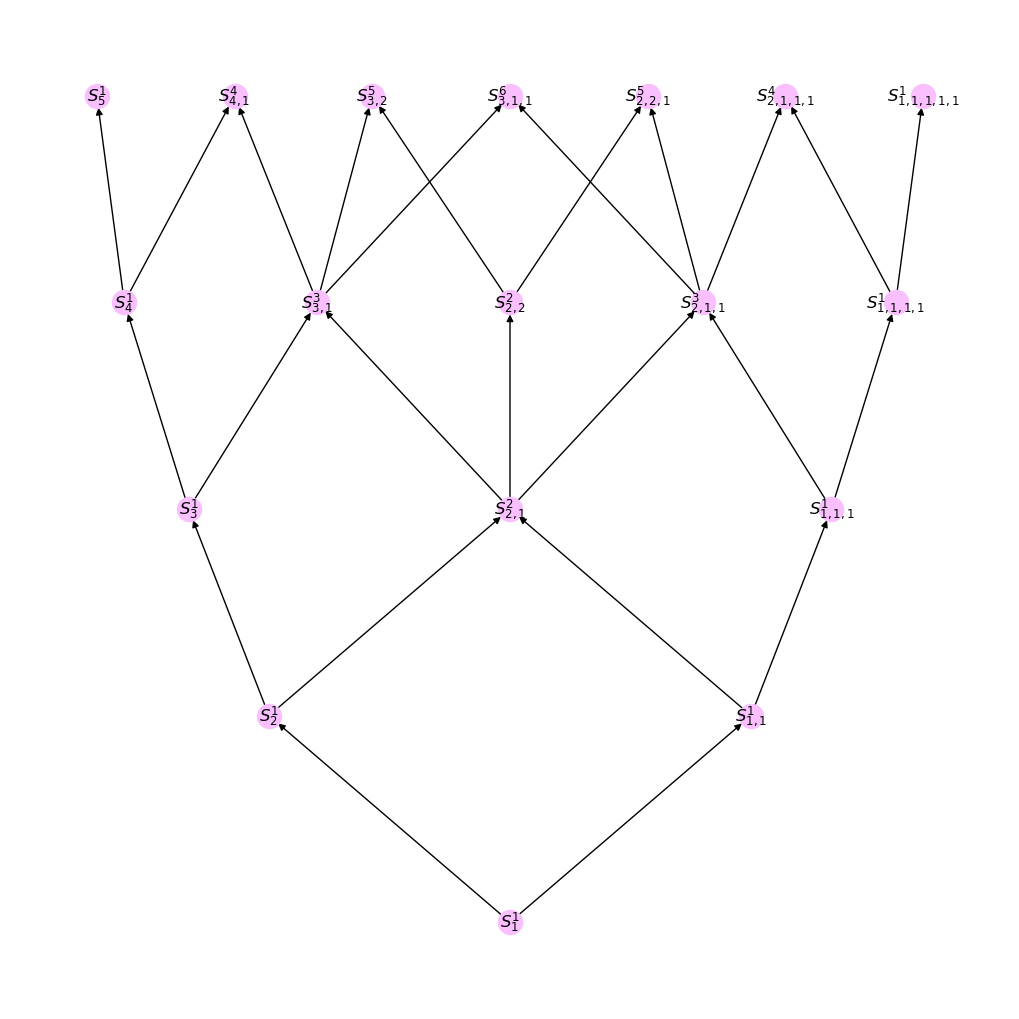

In [39]:
plot(left_multiplication, tensor_algebra, True)

In [40]:
def reverse_permutation(n):
    return Permutation(list(range(1, n + 1))[::-1])


def derive_reverse_actions(tensor_algebra):
    reverse_actions = {}

    for degree in tensor_algebra:
        for partition in tensor_algebra[degree]:
            n = sum(partition)

            specht_module = SpechtModuleWithBasis(SymmetricGroupAlgebra(QQ, n), partition)

            reverse_actions[partition] = SparseMatrix(specht_module.representation_matrix_in_basis(
                tensor_algebra[degree][partition], reverse_permutation(n)).numpy())

    return reverse_actions

In [41]:
def derive_right_multiplication(tensor_algebra, left_multiplication):
    reverse_actions = derive_reverse_actions(tensor_algebra)

    right_multiplication = {}

    for degree_from in left_multiplication:
        right_multiplication[degree_from] = {}

        for partition_from, partition_to in left_multiplication[degree_from]:
            right_multiplication[degree_from][(partition_from, partition_to)] = reverse_actions[partition_to] @ left_multiplication[degree_from][(
                partition_from, partition_to)] @ reverse_actions[partition_from]

    return right_multiplication

In [42]:
right_multiplication = derive_right_multiplication(tensor_algebra, left_multiplication)
plot(right_multiplication, tensor_algebra, False)

AttributeError: 'Diagrams_with_category.element_class' object has no attribute '_SageObject__custom_name'

In [ ]:
def construct_bracket(left_multiplication, right_multiplication):
    bracket = {}

    for degree_from in left_multiplication:
        bracket[degree_from] = {}

        for non_zero_map in left_multiplication[degree_from]:
            new_map = left_multiplication[degree_from][non_zero_map] - \
                right_multiplication[degree_from][non_zero_map]

            if new_map.rank() != 0:
                bracket[degree_from][non_zero_map] = new_map

    return bracket

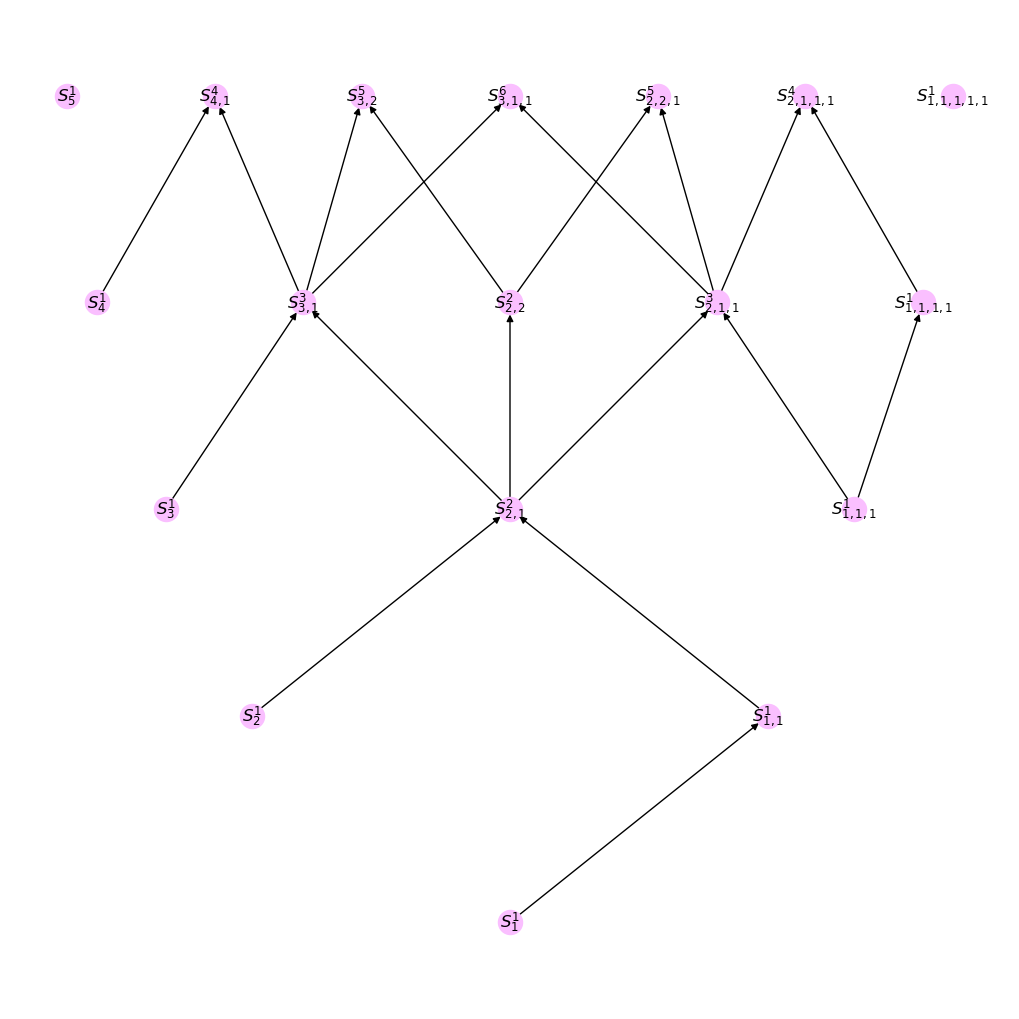

In [ ]:
bracket = construct_bracket(left_multiplication, right_multiplication)
plot(bracket, tensor_algebra, False)

In [ ]:
def generate_subalgebra(algebra, endomorphism, generators):
    subalgebra = {}

    subalgebra_matricies = {}

    for degree in generators:
        subalgebra[degree] = {}

        for partition in generators[degree]:
            n = len(algebra[degree][partition])

            subalgebra[degree][partition] = standard_basis(n)
            subalgebra_matricies[partition] = SparseMatrix(eye(n))

    for degree_from in endomorphism:
        degree_to = degree_from + 1

        if degree_from >= min(generators.keys()):
            for partition_from, partition_to in endomorphism[degree_from]:
                if not degree_to in subalgebra:
                    subalgebra[degree_to] = {}

                if partition_from in subalgebra[degree_from]:
                    for element in subalgebra[degree_from][partition_from]:
                        new_element = endomorphism[degree_from][(
                            partition_from, partition_to)] @ element

                        if partition_to in subalgebra[degree_to]:
                            new_matrix = subalgebra_matricies[partition_to].row_join(new_element)

                            if new_matrix.rank() > subalgebra_matricies[partition_to].rank():
                                subalgebra_matricies[partition_to] = new_matrix
                                subalgebra[degree_to][partition_to].append(new_element)
                        elif not new_element.rank() == 0:
                            subalgebra[degree_to][partition_to] = [new_element]
                            subalgebra_matricies[partition_to] = new_element

    restricted_endomorphism = {}

    for degree_from in endomorphism:
        degree_to = degree_from + 1

        restricted_endomorphism[degree_from] = {}

        for partition_from, partition_to in endomorphism[degree_from]:
            if partition_from in subalgebra[degree_from] and partition_to in subalgebra[degree_to]:
                restricted_endomorphism[degree_from][(
                    partition_from, partition_to)] = endomorphism[degree_from][(partition_from, partition_to)]

    return subalgebra, restricted_endomorphism

In [ ]:
def construct_free_lie_algebra(n):
    tensor_algebra, left_multiplication = construct_tensor_algebra(n)
    right_multiplication = derive_right_multiplication(tensor_algebra, left_multiplication)
    commutator = construct_bracket(left_multiplication, right_multiplication)
    return generate_subalgebra(tensor_algebra, commutator, {1: [Partition([1])]})

\documentclass{report}
\usepackage{tikz}
\usepackage{subcaption}

\begin{document}
\begin{figure}
  \begin{tikzpicture}
      \draw
        (6.0, 0.0) node (d1p1){$S^{1}_{1}$}
        (6.0, 2.0) node (d2p1c1){$S^{1}_{1, 1}$}
        (6.0, 4.0) node (d3p2c1){$S^{1}_{2, 1}$}
        (3.0, 6.0) node (d4p3c1){$S^{1}_{3, 1}$}
        (9.0, 6.0) node (d4p2c1c1){$S^{1}_{2, 1, 1}$}
        (1.2, 8.0) node (d5p4c1){$S^{1}_{4, 1}$}
        (3.6, 8.0) node (d5p3c2){$S^{1}_{3, 2}$}
        (6.0, 8.0) node (d5p3c1c1){$S^{2}_{3, 1, 1}$}
        (8.4, 8.0) node (d5p2c2c1){$S^{1}_{2, 2, 1}$}
        (10.8, 8.0) node (d5p2c1c1c1){$S^{1}_{2, 1, 1, 1}$}
        (0.75, 10.0) node (d6p5c1){$S^{1}_{5, 1}$}
        (2.25, 10.0) node (d6p4c2){$S^{2}_{4, 2}$}
        (3.75, 10.0) node (d6p4c1c1){$S^{3}_{4, 1, 1}$}
        (5.25, 10.0) node (d6p3c3){$S^{1}_{3, 3}$}
        (6.75, 10.0) node (d6p3c2c1){$S^{4}_{3, 2, 1}$}
        (8.25, 10.0) node (d6p3c1c1c1){$S^{3}_{3, 1, 1, 1}$}
        (9.75, 10.0) node (d6p2

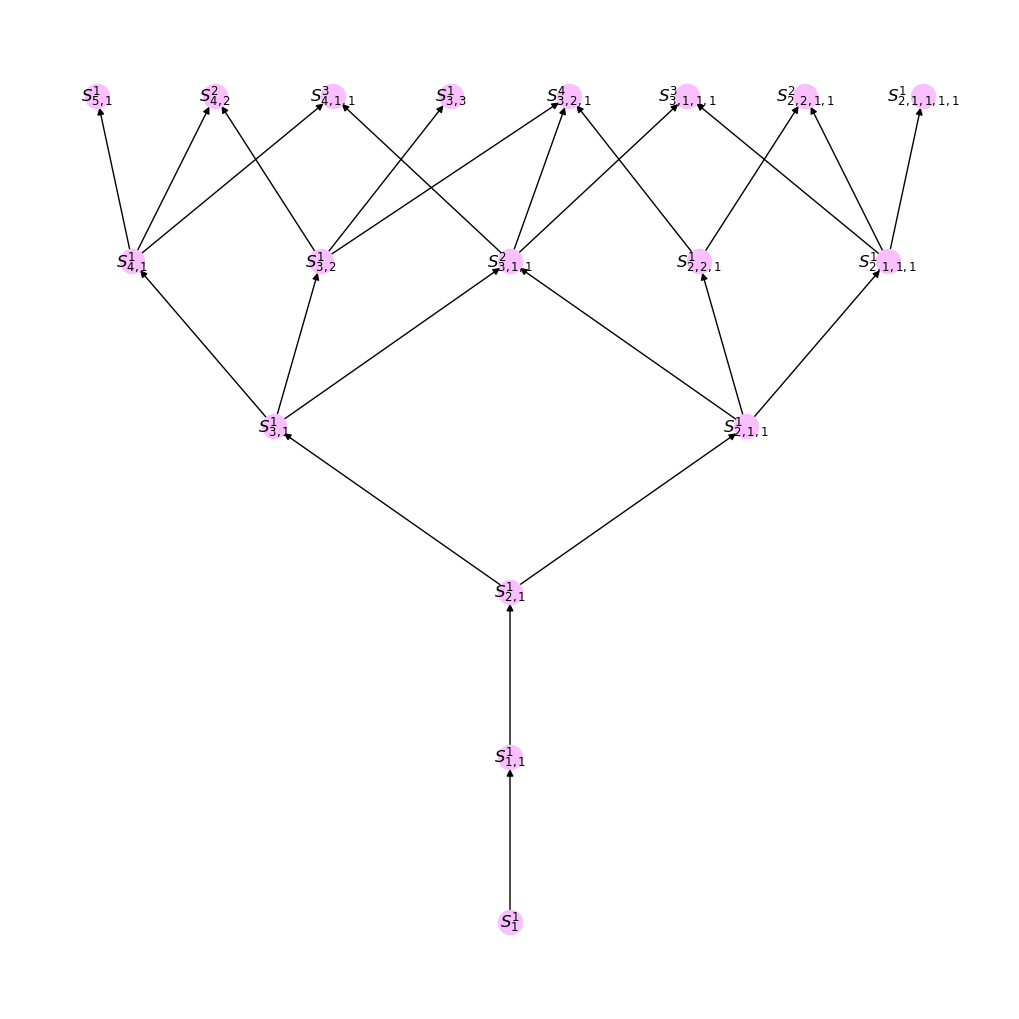

In [ ]:
free_lie_algebra, bracket = construct_free_lie_algebra(6)
plot(bracket, free_lie_algebra, True)

## Everything past here is temporary testing code


In [47]:
def lie(n):
    p = SymmetricFunctions(QQ).p()
    return p.sum_of_terms((Partition([d for j in range(ZZ(n / d))]), moebius(d) / n) for d in divisors(n))


s = SymmetricFunctions(QQ).schur()
[s(lie(i)) for i in range(1, 9)]

[s[1],
 s[1, 1],
 s[2, 1],
 s[2, 1, 1] + s[3, 1],
 s[2, 1, 1, 1] + s[2, 2, 1] + s[3, 1, 1] + s[3, 2] + s[4, 1],
 s[2, 1, 1, 1, 1] + 2*s[2, 2, 1, 1] + s[3, 1, 1, 1] + 3*s[3, 2, 1] + s[3, 3] + 2*s[4, 1, 1] + s[4, 2] + s[5, 1],
 s[2, 1, 1, 1, 1, 1] + 2*s[2, 2, 1, 1, 1] + 2*s[2, 2, 2, 1] + 2*s[3, 1, 1, 1, 1] + 5*s[3, 2, 1, 1] + 3*s[3, 2, 2] + 3*s[3, 3, 1] + 3*s[4, 1, 1, 1] + 5*s[4, 2, 1] + 2*s[4, 3] + 2*s[5, 1, 1] + 2*s[5, 2] + s[6, 1],
 s[2, 1, 1, 1, 1, 1, 1] + 2*s[2, 2, 1, 1, 1, 1] + 4*s[2, 2, 2, 1, 1] + s[2, 2, 2, 2] + 3*s[3, 1, 1, 1, 1, 1] + 8*s[3, 2, 1, 1, 1] + 9*s[3, 2, 2, 1] + 6*s[3, 3, 1, 1] + 6*s[3, 3, 2] + 4*s[4, 1, 1, 1, 1] + 12*s[4, 2, 1, 1] + 6*s[4, 2, 2] + 9*s[4, 3, 1] + s[4, 4] + 4*s[5, 1, 1, 1] + 8*s[5, 2, 1] + 4*s[5, 3] + 3*s[6, 1, 1] + 2*s[6, 2] + s[7, 1]]

In [48]:
free_lie_algebra, bracket = construct_free_lie_algebra(6)
reverse_actions = derive_reverse_actions(tensor_algebra)

In [49]:
free_lie_algebra[3][Partition([2, 1])]

[Matrix([
 [-2],
 [ 4]])]

In [50]:
bracket[4][(Partition([2, 1, 1]), Partition([3, 1, 1]))
           ] @ bracket[3][(Partition([2, 1]), Partition([2, 1, 1]))
                          ] @ bracket[2][(Partition([1, 1]), Partition([2, 1]))
                                         ]

Matrix([
[-1],
[-1],
[ 2],
[ 1],
[ 0],
[-1]])

In [51]:

bracket[4][(Partition([3, 1]), Partition([3, 1, 1]))
           ] @ bracket[3][(Partition([2, 1]), Partition([3, 1]))
                          ] @ bracket[2][(Partition([1, 1]), Partition([2, 1]))
                                         ]

Matrix([
[-2],
[ 0],
[ 2],
[ 0],
[ 0],
[ 0]])

In [52]:
reverse_actions[Partition([2, 1, 1])]

Matrix([
[ 0, -1, -1],
[-1,  0,  1],
[ 0,  0, -1]])

In [53]:
reverse_actions[Partition([3, 1])]

Matrix([
[-1, -1, -1],
[ 0,  0,  1],
[ 0,  1,  0]])

In [54]:
reverse_actions[Partition([3, 1, 1])]

Matrix([
[ 0,  0, -1,  0, -1, -1],
[ 0, -1,  0, -1,  0,  1],
[-1,  0,  0,  1,  1,  0],
[ 0,  0,  0,  0,  0, -1],
[ 0,  0,  0,  0, -1,  0],
[ 0,  0,  0, -1,  0,  0]])

In [55]:
s_tableaux = tensor_algebra[5][Partition([3, 1, 1])]

for tableaux in s_tableaux:
    tableaux.pp()
    print('')

  1  2  3
  4
  5

  1  2  4
  3
  5

  1  3  4
  2
  5

  1  2  5
  3
  4

  1  3  5
  2
  4

  1  4  5
  2
  3



In [56]:
def convert_to_row_standard(tableau):
    for rho in tableau.row_stabilizer():
        permuted_tableau = tableau.symmetric_group_action_on_entries(Permutation(
            rho.cycle_tuples()))

        try:
            RowStandardTableau(permuted_tableau).check()
            return permuted_tableau
        except:
            pass

In [57]:
convert_to_row_standard(Tableau([[1, 3, 2], [4]]))

[[1, 2, 3], [4]]

In [58]:
s_tableaux_image = []

for tableaux in s_tableaux:
    s_tableaux_image.append({convert_to_row_standard(tableaux.symmetric_group_action_on_entries(Permutation(
        sigma.cycle_tuples()))): sigma.sign() for sigma in tableaux.column_stabilizer()})

s_tableaux_image[0]

{[[1, 2, 3], [4], [5]]: 1,
 [[2, 3, 4], [5], [1]]: 1,
 [[2, 3, 5], [1], [4]]: 1,
 [[1, 2, 3], [5], [4]]: -1,
 [[2, 3, 4], [1], [5]]: -1,
 [[2, 3, 5], [4], [1]]: -1}

In [59]:
def apply(permutation, tableaux_image):
    return {convert_to_row_standard(tableaux.symmetric_group_action_on_entries(permutation)): tableaux_image[tableaux] for tableaux in tableaux_image}

In [60]:
permutated_s_tableaux_image = [apply(reverse_permutation(5), tableaux_image)
                               for tableaux_image in s_tableaux_image]

permutated_s_tableaux_image[0]

{[[3, 4, 5], [2], [1]]: 1,
 [[2, 3, 4], [1], [5]]: 1,
 [[1, 3, 4], [5], [2]]: 1,
 [[3, 4, 5], [1], [2]]: -1,
 [[2, 3, 4], [5], [1]]: -1,
 [[1, 3, 4], [2], [5]]: -1}

In [61]:
def add_images(tableaux_image_first, tableaux_image_second):
    new_tableaux_image = tableaux_image_first.copy()

    for tableaux in tableaux_image_second:
        if tableaux not in new_tableaux_image:
            new_tableaux_image[tableaux] = tableaux_image_second[tableaux]
        else:
            new_tableaux_image[tableaux] += tableaux_image_second[tableaux]

    new_tableaux_image_filtered = {}

    for tableaux in new_tableaux_image:
        if not new_tableaux_image[tableaux] == 0:
            new_tableaux_image_filtered[tableaux] = new_tableaux_image[tableaux]

    return new_tableaux_image_filtered

In [62]:
add_images(permutated_s_tableaux_image[0], permutated_s_tableaux_image[0])

{[[3, 4, 5], [2], [1]]: 2,
 [[2, 3, 4], [1], [5]]: 2,
 [[1, 3, 4], [5], [2]]: 2,
 [[3, 4, 5], [1], [2]]: -2,
 [[2, 3, 4], [5], [1]]: -2,
 [[1, 3, 4], [2], [5]]: -2}

In [63]:
def subtract_images(tableaux_image_first, tableaux_image_second):
    new_tableaux_image = tableaux_image_first.copy()

    for tableaux in tableaux_image_second:
        if tableaux not in new_tableaux_image:
            new_tableaux_image[tableaux] = -tableaux_image_second[tableaux]
        else:
            new_tableaux_image[tableaux] -= tableaux_image_second[tableaux]

    new_tableaux_image_filtered = {}

    for tableaux in new_tableaux_image:
        if not new_tableaux_image[tableaux] == 0:
            new_tableaux_image_filtered[tableaux] = new_tableaux_image[tableaux]

    return new_tableaux_image_filtered

In [64]:
print(add_images(permutated_s_tableaux_image[0], s_tableaux_image[2]))
print(add_images(permutated_s_tableaux_image[1], s_tableaux_image[1]))
print(add_images(permutated_s_tableaux_image[2], s_tableaux_image[0]))
print(add_images(permutated_s_tableaux_image[3], subtract_images(
    add_images(s_tableaux_image[1],  s_tableaux_image[5]), s_tableaux_image[2])))
print(add_images(permutated_s_tableaux_image[4], subtract_images(
    add_images(s_tableaux_image[0],  s_tableaux_image[4]), s_tableaux_image[2])))
print(add_images(permutated_s_tableaux_image[5], subtract_images(
    add_images(s_tableaux_image[0],  s_tableaux_image[3]), s_tableaux_image[1])))

{}
{}
{}
{}
{}
{}
